In [312]:
import glob
import pickle
import scrapy
import requests
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

In [37]:
# TODO, get data table from website

In [3]:
data = pickle.load(data, open('data-table', 'wb'))

In [16]:
data

,Name,Abk.,Höhe,Klimaregion,Unnamed: 4
0,Basel / Binningen,BAS,316 m. ü. M.,Östlicher Jura,"homog_mo_BAS (TXT, DE)"
1,Bern / Zollikofen,BER,553 m. ü. M.,Zentrales Mittelland,"homog_mo_BER (TXT, DE)"
2,Chaumont,CHM,1136 m. ü. M.,Westlicher Jura,"homog_mo_CHM (TXT, DE)"
3,Château-d'Oex,CHD,1029 m. ü. M.,Westlicher Alpennordhang,"homog_mo_CHD (TXT, DE)"
4,Col du Grand St-Bernard,GSB,2472 m. ü. M.,Alpensüdseite,"homog_mo_GSB (TXT, DE)"
5,Davos,DAV,1594 m. ü. M.,Nord- und Mittelbünden,"homog_mo_DAV (TXT, DE)"
6,Engelberg,ENG,1036 m. ü. M.,Zentraler Alpennordhang,"homog_mo_ENG (TXT, DE)"
7,Genève-Cointrin,GVE,412 m. ü. M.,Westliches Mittelland,"homog_mo_GVE (TXT, DE)"
8,Lugano,LUG,273 m. ü. M.,Alpensüdseite,"homog_mo_LUG (TXT, DE)"
9,Payerne,PAY,490 m. ü. M.,Westliches Mittelland,"homog_mo_PAY (TXT, DE)"


In [30]:
session = requests.session()

In [35]:
link = "https://www.meteoschweiz.admin.ch/product/output/climate-data/homogenous-monthly-data-processing/data/homog_mo_{}.txt"
for key in data['Abk.']:
    response = session.get(link.format(key))
    response.encoding = 'utf-8'
    f = open("data/{}.txt".format(key), "w")
    f.write(response.text)
    f.close()

In [89]:
def parse_temp_file(filename):
    file = open(filename, "r")
    content = file.readlines()
    columns = content[27].split()
    data = [line.split() for line in content[28:]]
    df = pd.DataFrame.from_records(data, columns=columns)
    df['Station'] = content[5].split(":")[1].strip()
    df['Altitude'] = content[6].split(":")[1].strip()[0:-2]
    df['Coordinates'] = content[7].split(":")[1].strip()
    return df

In [236]:
dfs = []
for filename in glob.glob("data/*.txt"):
    dfs.append(parse_temp_file(filename))
    
df = pd.concat(dfs)
for col in list(df):
    if col in ['Year', 'Month', 'Temperature', 'Precipitation', 'Altitude']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Exclude stations with missing temperatures
df = df[~(df.Station.isin(['Payerne', 'Château-d\'Oex']))]

In [229]:
df.head()

,Year,Month,Temperature,Precipitation,Station,Altitude,Coordinates
0,1864,1,-6.9,53.5,Engelberg,1036,46° 49.3' N / 8° 24.6' E
1,1864,2,-3.6,78.4,Engelberg,1036,46° 49.3' N / 8° 24.6' E
2,1864,3,1.5,69.8,Engelberg,1036,46° 49.3' N / 8° 24.6' E
3,1864,4,3.5,174.4,Engelberg,1036,46° 49.3' N / 8° 24.6' E
4,1864,5,9.3,240.6,Engelberg,1036,46° 49.3' N / 8° 24.6' E


In [228]:
df.groupby(['Station']).count()

,Year,Month,Temperature,Precipitation,Altitude,Coordinates
Station,,,,,,
Basel / Binningen,1867,1867,1867,1867,1867,1867
Bern / Zollikofen,1867,1867,1867,1867,1867,1867
Chaumont,1867,1867,1867,1867,1867,1867
Col du Grand St-Bernard,1867,1867,1867,1423,1867,1867
Davos,1867,1867,1867,1803,1867,1867
Engelberg,1867,1867,1867,1867,1867,1867
Genève / Cointrin,1867,1867,1867,1867,1867,1867
Lugano,1867,1867,1867,1867,1867,1867
Segl-Maria,1867,1867,1867,1867,1867,1867


In [251]:
sns.set_style("whitegrid")

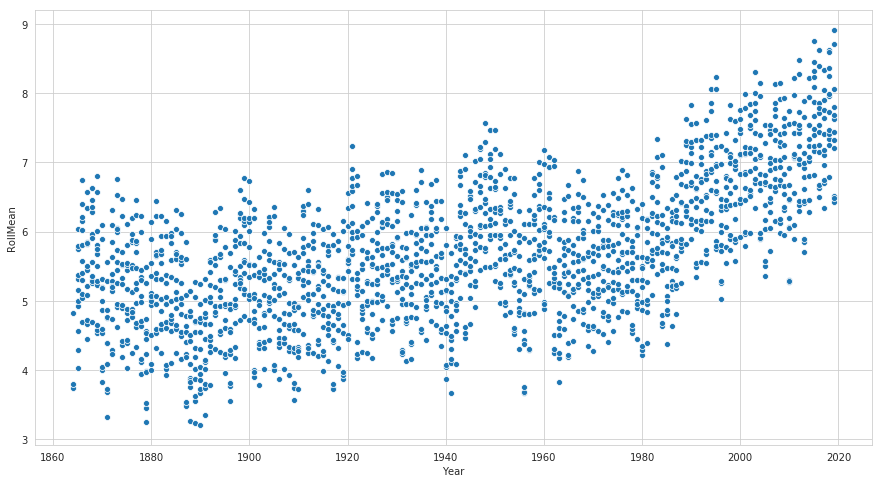

In [261]:
diff = df.groupby(["Year", "Station"]) \
    .mean() \
    .reset_index()
diff["RollMean"] = diff.Temperature.rolling(10).mean()

fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(
    x = 'Year',
    y = 'RollMean',
    data = diff,
)

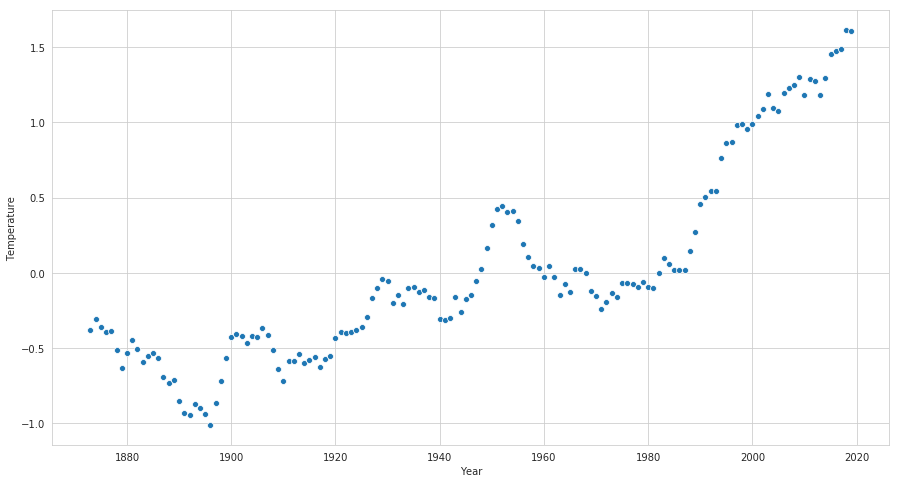

In [262]:
months = df.groupby(["Year", "Month"]).mean().unstack().rolling(10).mean().stack().reset_index()

months.Temperature = months.Temperature - months.groupby("Month").transform("mean")['Temperature']

fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(
    x = 'Year',
    y = 'Temperature',
    data = months.groupby(['Year']).mean().reset_index(),
)

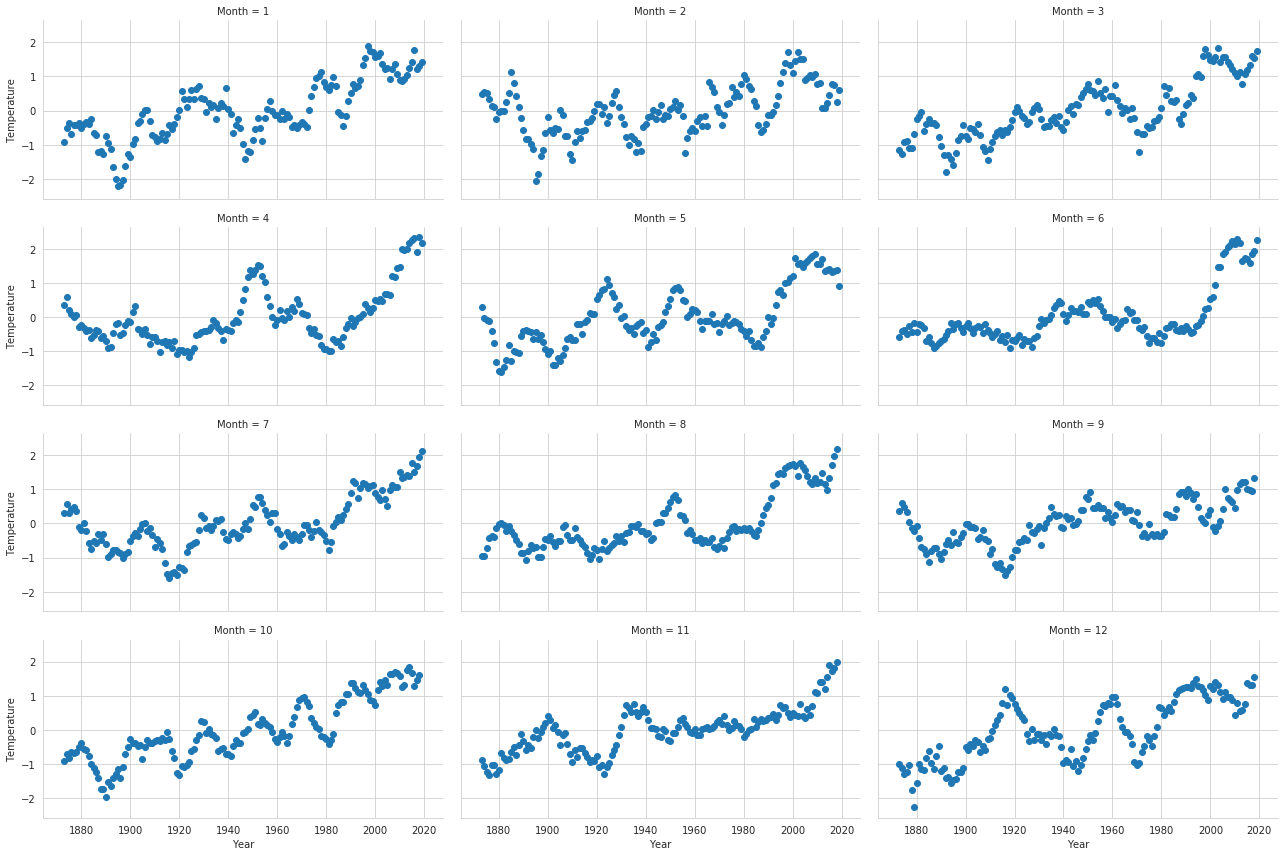

In [243]:
g = sns.FacetGrid(months, col="Month", col_wrap=3, aspect=2)
g = g.map(plt.scatter, "Year", "Temperature")

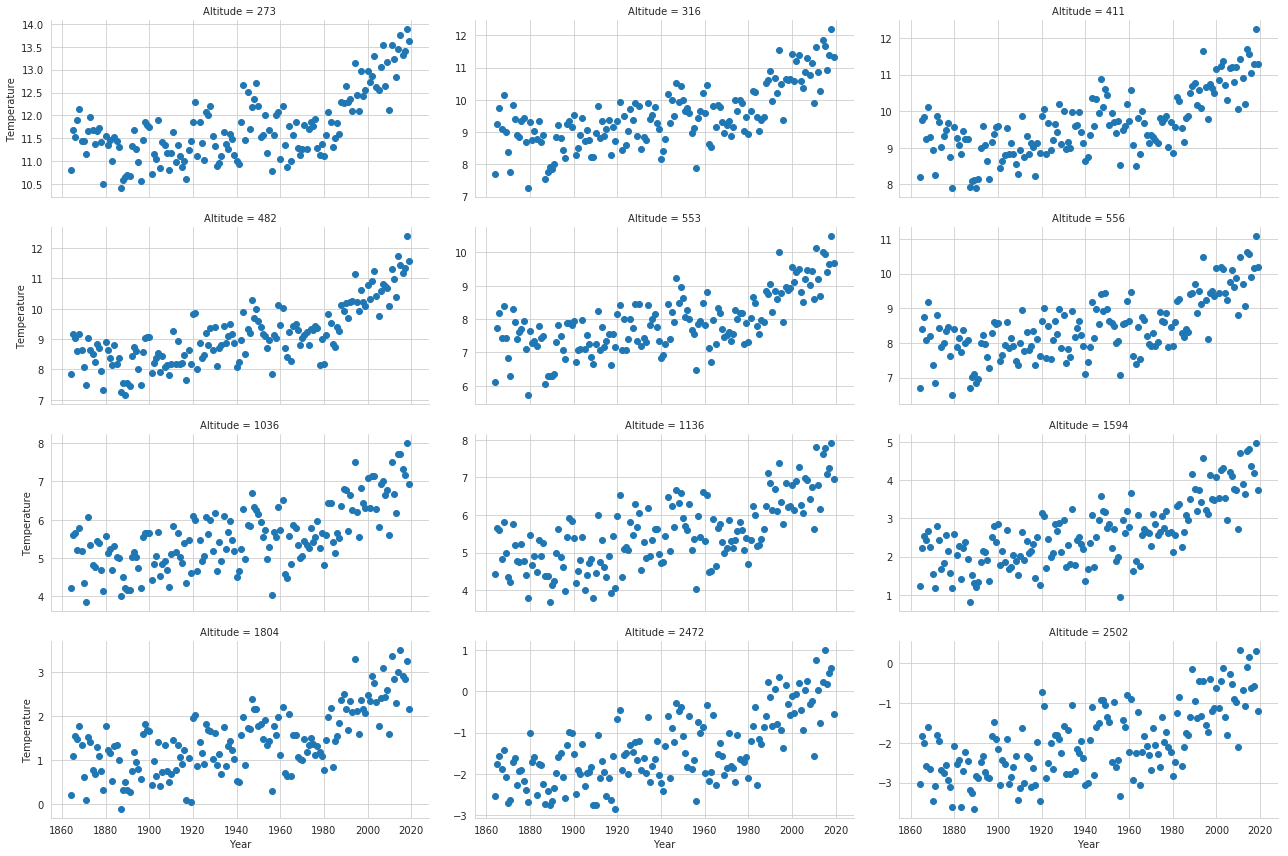

In [244]:
altitudes = df.groupby(["Altitude", "Year"]).mean().reset_index()
g = sns.FacetGrid(altitudes, col="Altitude", col_wrap=3, aspect=2, sharey=False)
g = g.map(plt.scatter, "Year", "Temperature")

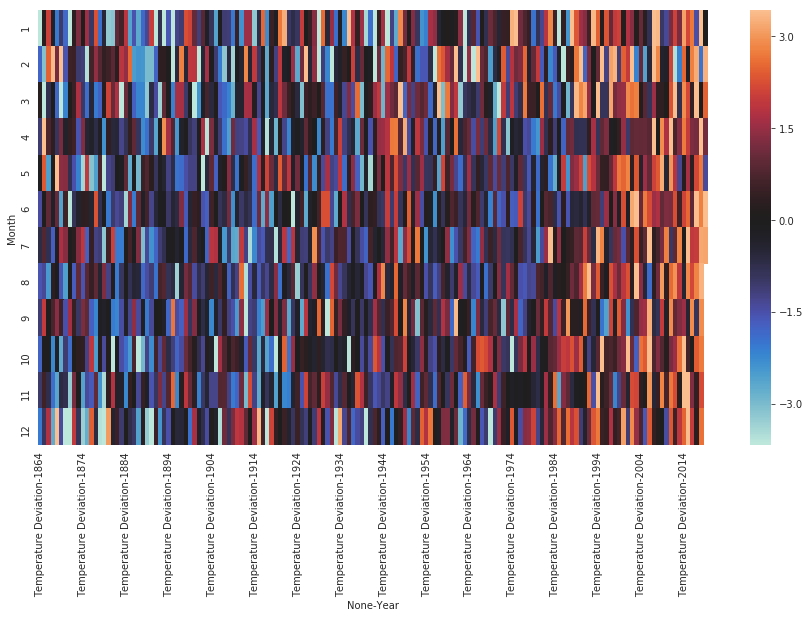

In [332]:
heatmap = df.copy()
heatmap = df.groupby(['Year', 'Month']).mean().reset_index()
heatmap['Temperature Deviation'] = heatmap.Temperature - heatmap.groupby(['Month']).transform('mean')['Temperature']
heatmap = heatmap.groupby(['Month', 'Year']).mean()[['Temperature Deviation']].unstack()

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    heatmap,
    center = 0,
    robust = True,
    xticklabels = 10
)